In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as si


# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

In [54]:
def greeks(S, K, T, r, sigma):
    """
    Calculate the Greeks of a European call option using the Black-Scholes model.
    
    Parameters:
    S: Current stock price.
    K: Strike price of the option.
    T: Time to expiration in years.
    r: Risk-free interest rate (annualized).
    sigma: Volatility of the underlying stock (annualized).
    
    Returns:
        A dictionary containing the Greeks: Delta, Gamma, Vega, Theta, Rho.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta = si.norm.cdf(d1)
    gamma = si.norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * si.norm.pdf(d1) * np.sqrt(T)
    theta = (-S * si.norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - 
             r * K * np.exp(-r * T) * si.norm.cdf(d2))
    rho = K * T * np.exp(-r * T) * si.norm.cdf(d2)
    
    return {
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega,
        'Theta': -theta,
        'Rho': rho
    }

def get_outliers_std(df, column, n_std=3):
    media = df[column].mean()
    std = df[column].std()
    return df[np.abs(df[column] - media) > n_std * std]

def compare_greeks_with_partials(greeks_obs, descaled_derivs):
    """
    Compara los Greeks con las derivadas parciales desescaladas.
    """
    print("\n--- Comparison: Greeks vs NeuralSens Partial Derivatives ---")
    
    # Delta ~ dPrice/dS
    delta_nn = descaled_derivs['num__S_descaled']
    print(f"Delta (BS): {greeks_obs['Delta']:.4f} | ∂Price/∂S (MLP): {delta_nn:.4f}")

    # Vega ~ dPrice/dSigma (ojo: en BS suele estar expresado en unidades de %)
    vega_nn = descaled_derivs['num__sigma_descaled']
    print(f"Vega (BS): {greeks_obs['Vega']:.4f} | ∂Price/∂sigma (MLP): {vega_nn:.4f}")

    # Theta ~ ∂Price/∂T (sign flip habitualmente)
    theta_nn = descaled_derivs['num__T_descaled']
    print(f"Theta (BS): {greeks_obs['Theta']:.4f} | ∂Price/∂T (MLP): {theta_nn:.4f}")

def analyze_observation(df_partDeriv, df_original, column, pos, outliers: bool):
    searched_derivative = 'num__' + column
    df_outliers = get_outliers_std(df_partDeriv, searched_derivative, n_std=3)

    original_indexes = df_original.index.tolist()
    derivatives_indexes = df_partDeriv.index.tolist()
    index_mapping = {original: derivative for original, derivative in zip(original_indexes, derivatives_indexes)}

    if(outliers):
        df_observations = df_outliers
        observation = "outliers"
        observed_dataframe = 'outliers_' + column

    else:
        df_observations = df_partDeriv[~df_partDeriv.index.isin(df_outliers.index)]
        observation = "not outliers"
        observed_dataframe = 'no_outliers_' + column
        

    # 1. Get original option values
    original = df_original.iloc[df_observations.index].reset_index(drop=False).rename(columns={'index': 'orig_index'})

    # 2. Select one example
    obs = original.iloc[pos]
    print(f"Analyzing {observation} at position {pos} in the {observed_dataframe} DataFrame:")
    print(obs)
    
    # 3. Compute Greeks for the original option values
    greeks_obs = greeks(obs['S'], obs['K'], obs['T'], 0.045, obs['sigma'])
    print("\nBS-computed Greeks for the original option values:")
    for greek, value in greeks_obs.items():
        if greek not in ['Rho', 'Gamma']:
            print(f"{greek}: {value:.4f}")
    
    # 4. Recover derivatives
    derivs_obs = df_partDeriv.loc[index_mapping[obs.orig_index]]

    descaled_derivs = derivs_obs[[col for col in df_partDeriv.columns if col.endswith('_descaled')]]
    print("\nDescaled partial derivatives:")
    for col in descaled_derivs.index:
        if col not in ['num__K_descaled']:
            col_name = col.split('__')[-1].replace('_descaled', '')
            col_name = col_name.replace('num__', '')
            col_name = col_name + ' derivative'
            print(f"{col_name}: {descaled_derivs[col]:.4f}")
    compare_greeks_with_partials(greeks_obs, descaled_derivs)

    return obs['MLP_better']


def plot_partial_derivative_distributions(df):
    """
    Dibuja histogramas con líneas de media y mediana para cada derivada parcial desescalada.
    
    Args:
        df (pd.DataFrame): DataFrame con columnas como num__S_descale, num__K_descale, etc.
    """
    # Filtramos solo columnas desescaladas
    cols = [col for col in df.columns if col.endswith('_descaled')]
    
    n_cols = len(cols)
    n_rows = (n_cols + 1) // 2  # dos columnas por fila
    
    plt.figure(figsize=(14, 5 * n_rows))
    
    for i, column in enumerate(cols, 1):
        plt.subplot(n_rows, 2, i)
        sns.histplot(df[column], kde=True, bins=100, color='steelblue')
        plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Mean: {df[column].mean():.2f}")
        plt.axvline(df[column].median(), color='green', linestyle=':', label=f"Median: {df[column].median():.2f}")
        
        # Extraemos el nombre original de la variable (S, K, T, sigma)
        feature_name = column.split('__')[-1].replace('_descaled','')
        plt.title(f"∂Price/∂{feature_name}")
        
        plt.xlabel("Partial derivative value")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    

### Data load

In [24]:
# Load dfTR_eval with indexes
dfTR_eval = pd.read_csv('../data/predicted/dfTR_eval.csv', index_col=0)
df_partDeriv = pd.read_csv('../data/predicted/df_partDeriv.csv', index_col=0)

### Global Greeks comparison

In [25]:
dfTR_eval_greeks = pd.read_csv('../data/predicted/dfTR_eval_greeks.csv', index_col=0)

# Compute median and mean of the Greeks
print("\n--- Greeks Summary Statistics ---")
print("Median Greeks:")
print(dfTR_eval_greeks[['Delta', 'Vega', 'Theta']].median())
print("\nMean Greeks:")
print(dfTR_eval_greeks[['Delta', 'Vega', 'Theta']].mean())

# Compute median and mean of the partial derivatives
print("\n--- Partial Derivatives Summary Statistics ---")
print("Median Partial Derivatives:")
print(df_partDeriv[[col for col in df_partDeriv.columns if col.endswith('_descaled')]].median())
print("\nMean Partial Derivatives:")
print(df_partDeriv[[col for col in df_partDeriv.columns if col.endswith('_descaled')]].mean())
# Plot distributions of partial derivatives


--- Greeks Summary Statistics ---
Median Greeks:
Delta     0.592418
Vega     15.039246
Theta    14.973269
dtype: float64

Mean Greeks:
Delta     0.542837
Vega     47.625761
Theta    40.136525
dtype: float64

--- Partial Derivatives Summary Statistics ---
Median Partial Derivatives:
num__S_descaled         0.505195
num__K_descaled        -0.400777
num__T_descaled        26.505447
num__sigma_descaled    39.685847
dtype: float64

Mean Partial Derivatives:
num__S_descaled         0.525038
num__K_descaled        -0.420971
num__T_descaled        65.641988
num__sigma_descaled   -60.370504
dtype: float64


### Sigma outliers analysis

In [48]:
outliers_sigma = get_outliers_std(df_partDeriv, 'num__sigma', n_std=3)
outlier_rows_sigma = dfTR_eval.iloc[outliers_sigma.index]
analyze_observation(df_partDeriv, dfTR_eval, 'sigma', 4, outliers=True)

Analyzing outliers at position 4 in the outliers_sigma DataFrame:
orig_index       118719
S                 167.1
K                  87.5
T              0.531507
sigma           0.00001
midPrice           33.8
BS_predict    81.667979
MLP_pred      48.070726
MLP_diff      14.270726
BS_diff       47.867979
MLP_better         True
Name: 4, dtype: object

BS-computed Greeks for the original option values:
Delta: 1.0000
Vega: 0.0000
Theta: 3.8444

Descaled partial derivatives:
S derivative: 0.6809
T derivative: 29.3248
sigma derivative: -2762.3706

--- Comparison: Greeks vs NeuralSens Partial Derivatives ---
Delta (BS): 1.0000 | ∂Price/∂S (NN): 0.6809
Vega (BS): 0.0000 | ∂Price/∂sigma (NN): -2762.3706
Theta (BS): 3.8444 | ∂Price/∂T (NN): 29.3248


### S outliers analysis

In [57]:
outliers_S = get_outliers_std(df_partDeriv, 'num__S')
outlier_rows_S = dfTR_eval.iloc[outliers_S.index]
analyze_observation(df_partDeriv, dfTR_eval, 'S', 7, outliers=True)

Analyzing outliers at position 7 in the outliers_S DataFrame:
orig_index         91158
S                1241.47
K                  780.0
T               2.526027
sigma           0.526666
midPrice           604.5
BS_predict    652.762562
MLP_pred      639.199718
MLP_diff       34.699718
BS_diff        48.262562
MLP_better          True
Name: 7, dtype: object

BS-computed Greeks for the original option values:
Delta: 0.8664
Vega: 425.3361
Theta: 63.3687

Descaled partial derivatives:
S derivative: 1.3980
T derivative: 212.9347
sigma derivative: 261.4783

--- Comparison: Greeks vs NeuralSens Partial Derivatives ---
Delta (BS): 0.8664 | ∂Price/∂S (MLP): 1.3980
Vega (BS): 425.3361 | ∂Price/∂sigma (MLP): 261.4783
Theta (BS): 63.3687 | ∂Price/∂T (MLP): 212.9347


True

### T outliers analysis

In [66]:
outliers_T = get_outliers_std(df_partDeriv, 'num__T')
outlier_rows_T = dfTR_eval.iloc[outliers_T.index]
analyze_observation(df_partDeriv, dfTR_eval, 'T', 34, outliers=True)

Analyzing outliers at position 34 in the outliers_T DataFrame:
orig_index        124416
S                 576.22
K                  490.0
T               0.032877
sigma           1.413699
midPrice           111.5
BS_predict    108.415209
MLP_pred      111.402967
MLP_diff        0.097033
BS_diff         3.084791
MLP_better          True
Name: 34, dtype: object

BS-computed Greeks for the original option values:
Delta: 0.7782
Vega: 31.0773
Theta: 683.4634

Descaled partial derivatives:
S derivative: 0.6860
T derivative: 463.4519
sigma derivative: 19.2093

--- Comparison: Greeks vs NeuralSens Partial Derivatives ---
Delta (BS): 0.7782 | ∂Price/∂S (MLP): 0.6860
Vega (BS): 31.0773 | ∂Price/∂sigma (MLP): 19.2093
Theta (BS): 683.4634 | ∂Price/∂T (MLP): 463.4519


True

In [65]:
pos_mejor_MLP

[6,
 7,
 34,
 47,
 51,
 57,
 59,
 66,
 69,
 72,
 94,
 103,
 119,
 125,
 150,
 151,
 152,
 161,
 162,
 176,
 184,
 207,
 215,
 236,
 249,
 263,
 276,
 279,
 303,
 324,
 345,
 360,
 366,
 374,
 387,
 400,
 410,
 422,
 441,
 447,
 450,
 458,
 460,
 463,
 479,
 480,
 481,
 490,
 515,
 518,
 523,
 552,
 554,
 561,
 579,
 584,
 586,
 640,
 656,
 667,
 687,
 704,
 716,
 718,
 719,
 721,
 724,
 731,
 751,
 754,
 756,
 765,
 767,
 768,
 778,
 779,
 792,
 802,
 804,
 818,
 824,
 837,
 838,
 842,
 859,
 866,
 878,
 891,
 902,
 903,
 904,
 909,
 912,
 919,
 921,
 922,
 933,
 936,
 951,
 954,
 957,
 969,
 1021,
 1028,
 1045,
 1051,
 1060,
 1074,
 1093,
 1105,
 1112,
 1118,
 1119,
 1124,
 1125,
 1137,
 1138,
 1173,
 1176,
 1179,
 1189,
 1192,
 1197,
 1204,
 1206,
 1218,
 1234,
 1236,
 1241,
 1257,
 1276,
 1287,
 1298,
 1316,
 1319,
 1326,
 1330,
 1337,
 1346,
 1353,
 1358,
 1361,
 1363,
 1366,
 1382,
 1388,
 1390,
 1394,
 1397,
 1410,
 1412,
 1426,
 1437,
 1443,
 1451,
 1458,
 1460,
 1471,
 1477,
 1

In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

print("OUTLIERS de sigma")
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_sigma['midPrice'], outlier_rows_sigma['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_sigma['midPrice'], outlier_rows_sigma['MLP_pred'])))

print("OUTLIERS de T")
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_T['midPrice'], outlier_rows_T['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_T['midPrice'], outlier_rows_T['MLP_pred'])))

print("OUTLIERS de S")  
print("\tBS_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_S['midPrice'], outlier_rows_S['BS_predict'])))
print("\tMLP_diff RMSE:", np.sqrt(mean_squared_error(outlier_rows_S['midPrice'], outlier_rows_S['MLP_pred'])))

print("Numero de outliers de sigma:", len(outlier_rows_sigma))
print("Numero de outliers de T:", len(outlier_rows_T))
print("Numero de outliers de S:", len(outlier_rows_S))


OUTLIERS de sigma
	BS_diff RMSE: 161.89040831449233
	MLP_diff RMSE: 99.77888083095796
OUTLIERS de T
	BS_diff RMSE: 286.499021813977
	MLP_diff RMSE: 207.39905012548653
OUTLIERS de S
	BS_diff RMSE: 49.117329759204
	MLP_diff RMSE: 45.04007067790086
Numero de outliers de sigma: 4408
Numero de outliers de T: 2238
Numero de outliers de S: 1311


In [37]:
outlier_rows_sigma.value_counts('MLP_better')

MLP_better
False    2291
True     2117
Name: count, dtype: int64

In [40]:
outlier_rows_T.value_counts('MLP_better')

MLP_better
False    2007
True      231
Name: count, dtype: int64

In [42]:
outlier_rows_S.value_counts('MLP_better')

MLP_better
False    1149
True      162
Name: count, dtype: int64

In [30]:
# Sacar las filas que no son outliers pero de dfTR
non_outliers_sigma = dfTR_eval[~df_partDeriv.index.isin(outliers_sigma.index)]
non_outliers_T = dfTR_eval[~df_partDeriv.index.isin(outliers_T.index)]
non_outliers_S = dfTR_eval[~df_partDeriv.index.isin(outliers_S.index)]

print("NO OUTLIERS de sigma")
print("\tBS_diff medio:", non_outliers_sigma['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_sigma['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_sigma['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_sigma['MLP_diff'].median())

print("NO OUTLIERS de T")
print("\tBS_diff medio:", non_outliers_T['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_T['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_T['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_T['MLP_diff'].median())

print("NO OUTLIERS de S")
print("\tBS_diff medio:", non_outliers_S['BS_diff'].mean())
print("\tBS_diff mediano:", non_outliers_S['BS_diff'].median())
print("\tMLP_diff medio:", non_outliers_S['MLP_diff'].mean())
print("\tMLP_diff mediano:", non_outliers_S['MLP_diff'].median())


NO OUTLIERS de sigma
	BS_diff medio: 9.196119192502444
	BS_diff mediano: 1.0956680475914586
	MLP_diff medio: 11.18008293129198
	MLP_diff mediano: 3.763415612009164
NO OUTLIERS de T
	BS_diff medio: 9.785390521568596
	BS_diff mediano: 1.2112988581907675
	MLP_diff medio: 11.080126799177146
	MLP_diff mediano: 3.853686501924539
NO OUTLIERS de S
	BS_diff medio: 10.742066208280814
	BS_diff mediano: 1.2067094119571635
	MLP_diff medio: 12.04997194632072
	MLP_diff mediano: 3.8965364287153106


In [31]:
dfTR_eval_greeks = pd.read_csv('../data/predicted/dfTR_eval_greeks.csv', index_col=0)
vega_mean = dfTR_eval_greeks['Vega'].mean()
delta_mean = dfTR_eval_greeks['Delta'].mean()
theta_mean = dfTR_eval_greeks['Theta'].mean()

print("Vega media:", vega_mean)
print("Delta media:", delta_mean)
print("Theta media:", theta_mean)

Vega media: 47.625760930858824
Delta media: 0.5428369310207808
Theta media: 40.1365250526288


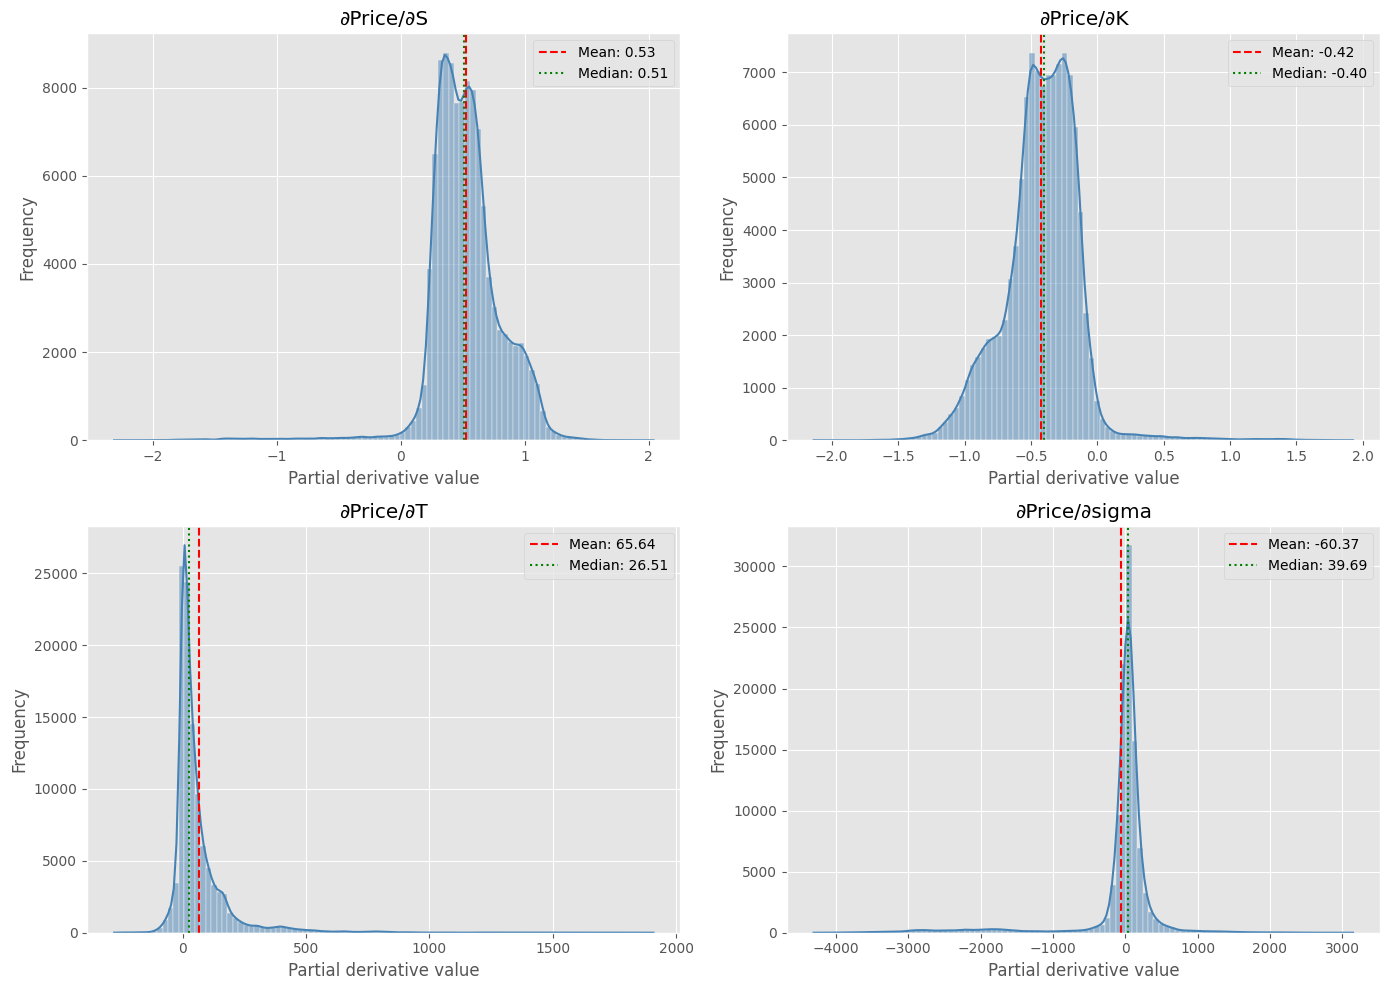

In [32]:
plot_partial_derivative_distributions(df_partDeriv)